In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib.colors import TwoSlopeNorm
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from scipy.ndimage import convolve
from skimage.io import imread

In [97]:
# import helper_functions

# Images and Convolutions
### The simple, complex and convoluted notions behind computer vision
## Part 2 - Convolutional neural networks

#### Helper functions

In [98]:
def plot_image_subplots(
        images,
        titles=None,
        subplot_kwargs=None,
        nrows=1,
        ncols=3,
        figsize_hor=12,
        figsize_ver=6,
        no_ticks=True
    ):
    """
    Plots a grid of images with titles, allowing for different keyword arguments for each subplot.

    Example usage:
    plot_image_subplots(
        images=[image_1, image_2, image_3],
        titles=["Title 1", "Title 2", "Title 3"],
        plot_kwargs=[
            {"cmap": "gray"},
            {"cmap": "Reds_r", "vmin": 0, "vmax": 1},
            {"cmap": "Blues_r", "vmin": -1, "vmax": 1}
        ],
        nrows=1,
        ncols=3,
        figsize_hor=15,
        figsize_ver=5
    )
    """
    if titles is None:
        titles = ["" for _ in images]
    else:
        assert len(images) == len(titles), "Number of images not equal to number of titles"

    if subplot_kwargs is None:
        subplot_kwargs = [{} for _ in images]
    else:
        assert len(images) == len(subplot_kwargs), "Number of images not equal to number of plot_kwargs"

    for kwargs in subplot_kwargs:
        if "cmap" not in kwargs:
            kwargs["cmap"] = "gray"

    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize_hor, figsize_ver))
    axs = axs.flatten()

    for i, (image, title) in enumerate(zip(images, titles)):
        axs[i].imshow(image, **subplot_kwargs[i])
        axs[i].set_title(title)

    if no_ticks:
        plt.setp(axs, xticks=[], yticks=[])

    plt.tight_layout()
    plt.show()


In [99]:

def limit_range(pixel_value, min_value = 0, max_value = 1):
    """
    Function to keep the range of pixel values; (0, 1) by default
    """
    if pixel_value < min_value:
        pixel_value = min_value
    elif pixel_value > max_value:
        pixel_value = max_value
    return pixel_value

limit_range = np.vectorize(limit_range)

In [100]:
def convolve_3_channel_image(image, filter):
    """
    Applies scipy.ndimage.convolve(image_channel, filter) separately on each channel of the image and
    returns the resulting convolutions stacked to resemble a color image.
    """
    return np.dstack([convolve(image[:, :, i], filter) for i in range(3)])

In [101]:
def plot_convolutions(image, filters, titles = None, subplot_kwargs = None, single_channel = True, **plot_kwargs):
    """
    Plot images resulting from convolution with given filters.
    """
    if single_channel:
        conv_results = [convolve(image, filter) for filter in filters]
    else:
        conv_results = [convolve_3_channel_image(image, filter) for filter in filters]


    plot_image_subplots(conv_results, titles, subplot_kwargs, **plot_kwargs)

In [102]:
def plot_heatmaps(arrays, titles = None, nrows = 1, ncols = 2, figsize_hor = 12, figsize_ver = 3, cmap_limit = 0.1):
    """
    Plots a heatmap of each array with a common colorbar.
    Heatmaps are zero-centered, blue indicating negative values, red - positive.

    """
    if titles is None:
        titles = ["" for _ in arrays]
    else:
        assert len(arrays) == len(titles), "Number of arrays not equal to number of titles"

    # Create the figure and axes
    fig, axs = plt.subplots(nrows, ncols, figsize = (figsize_hor, figsize_ver), layout = "compressed")
    if len(arrays) > 1:
        axs = axs.flatten()
    else:
        axs = [axs]

    # Find the global min and max values across all data for common scaling
    global_min = min(data.min() for data in arrays)
    global_max = max(data.max() for data in arrays)

    global_abs = max([abs(global_min), global_max])

    # Create a common normalization
    norm = TwoSlopeNorm(vmin = - cmap_limit - global_abs, vmax = cmap_limit + global_abs, vcenter = 0)

    # Plot each data array
    for ax, array, title in zip(axs, arrays, titles):
        cax = ax.imshow(array, cmap = "seismic", norm = norm)
        ax.set_title(title)

    # Add a single colorbar
    cbar = fig.colorbar(cax, ax=axs[:len(arrays)])

    # Remove axis ticks
    plt.setp(axs, xticks=[], yticks=[])


    plt.show()


### Minimalist CNN

Our cat ir rather unfit for the purpose of demonstrating how convolutional neural networks work. That is we would need vastly greater number of cats to make it work. Further more, recognizing a cat is a hard task - there are a lot of other things with eyes, nose and fur, so we would need wide and deep neural network and a lot of images, time, knowledge and skill to train it (and we have neither of those). So we will take the simplest image dataset in existense - MNIST, which happens to be readily available in Tensorflow Datasets. It consists of small grayscale images of handwritten digits, annotated which digit it is supposed to be.
We load our dataset, normalize pixel values and add an extra dimension to the images, because expected shape for an image is (width, height, channels).

In [103]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channels dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]


Let's take a look at our dataset:

In [104]:
train_images.shape

(60000, 28, 28, 1)

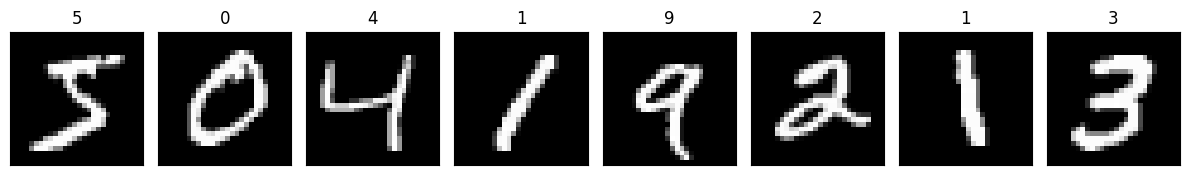

In [105]:
n_images = 8
plot_image_subplots(train_images[:n_images], titles=train_labels[:n_images], ncols = n_images, nrows = 1)

To make our task even more simple we make it a binary one - we will train a model to predict weather the digit is `8` or not. That means we need to convert our labels - 1 for "yes, this is an image of the digit eight" and 0 for "no, it is not an eight".

In [106]:
# Convert labels to binary: 1 for class '8', 0 for others
train_labels_bin = (train_labels == 8).astype(int)
test_labels_bin = (test_labels == 8).astype(int)

We define our convolutional model - as simple as possible - a sequential model with fixed input shape, convolutional layer with single kernel, layer for reshaping into 1d array and final dense layer with sigmoid activation. This essentially is logistic regression over the flattened convolution output - not even an actual neural network.

In [107]:
# Define the convolutional model
conv_model = Sequential([
    InputLayer((28, 28, 1)), # Input layer with the shape of our images
    Conv2D(1, (3, 3)), # Single convolutional layer with one 3 x 3 filter
    Flatten(),
    Dense(1, activation='sigmoid')  # Single output neuron for binary classification
])


In [108]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 1)         10        
                                                                 
 flatten_1 (Flatten)         (None, 676)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 677       
                                                                 
Total params: 687 (2.68 KB)
Trainable params: 687 (2.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We have 10 parameters in our convolutional layer - 3 x 3 - 9 values in the kernel and a bias term.

We compile the model with the basics, just add precision and recall since we turned our dataset in an unballanced one - there are far less eights than other digits combined.

In [109]:
# Compile the model
conv_model.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', 'Recall']) # ffff, with CAPITAL letter, why ...

And train the model on the train images with binary labels for a single epoch:

In [110]:
# Train the model
conv_history = conv_model.fit(train_images, train_labels_bin, epochs=1)



1875/1875 [==============================] - 15s 8ms/step - loss: 0.1795 - accuracy: 0.9380 - precision: 0.8387 - recall: 0.4505


And evaluate the model on the test set:

In [111]:
# Evaluate the model
conv_results = conv_model.evaluate(test_images, test_labels_bin, verbose=2)

# Print the results
print(f"Test Accuracy: {conv_results[1]}")
print(f"Test Precision: {conv_results[2]}")
print(f"Test Recall: {conv_results[3]}")

313/313 - 2s - loss: 0.1191 - accuracy: 0.9592 - precision: 0.8743 - recall: 0.6786 - 2s/epoch - 5ms/step
Test Accuracy: 0.9592000246047974
Test Precision: 0.8743386268615723
Test Recall: 0.6786447763442993


In [112]:
test_images_8 = test_images[test_labels == 8]
test_images_other = test_images[test_labels != 8]

In [113]:
n_images = 9

1/1 [==============================] - 0s 59ms/step


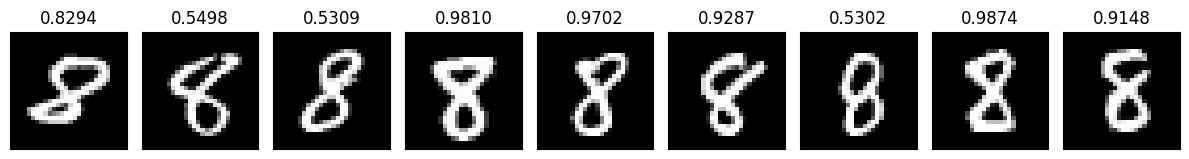

In [114]:
images_to_plot = test_images_8[:n_images]
predictions = conv_model.predict(images_to_plot)
titles = [f"{prob[0]:.4f}" for prob in predictions.tolist()]


plot_image_subplots(images_to_plot, titles=titles, ncols = n_images, nrows = 1, figsize_ver = 2)


1/1 [==============================] - 0s 23ms/step


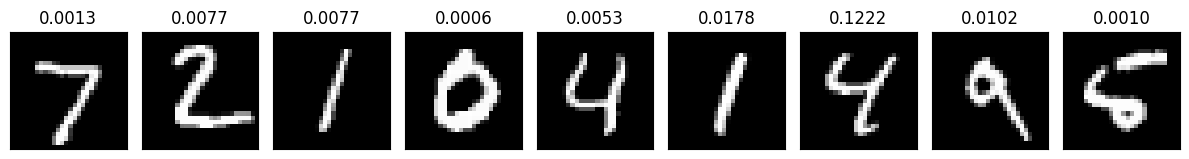

In [115]:
images_to_plot = test_images_other[:n_images]
predictions = conv_model.predict(images_to_plot)
titles = [f"{prob[0]:.4f}" for prob in predictions.tolist()]


plot_image_subplots(images_to_plot, titles=titles, ncols = n_images, nrows = 1, figsize_ver = 2)


In [116]:
conv_layer = conv_model.layers[0]
kernel_weights, bias = conv_layer.get_weights()
kernel_weights.shape

(3, 3, 1, 1)

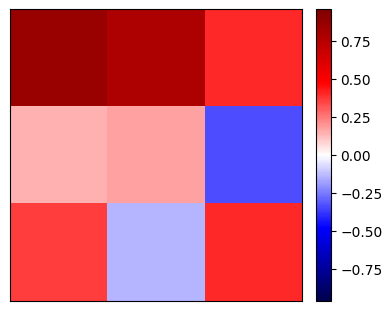

In [117]:
conv_filter = kernel_weights[:, :, 0, 0]
plot_heatmaps([conv_filter], ncols=1)

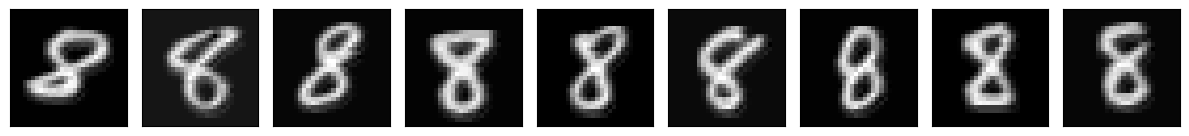

In [118]:
n_images = 9
images_to_plot = np.array([convolve(test_images_8[i][:, :, 0], conv_filter) for i in range(n_images)])

plot_image_subplots(images_to_plot, ncols = n_images, nrows = 1, figsize_ver = 2)

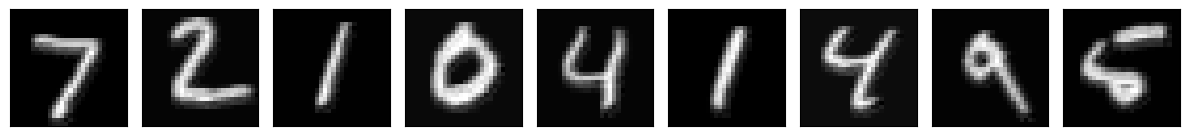

In [119]:
n_images = 9
images_to_plot = np.array([convolve(test_images_other[i][:, :, 0], conv_filter) for i in range(n_images)])

plot_image_subplots(images_to_plot, ncols = n_images, nrows = 1, figsize_ver = 2)

base

In [121]:
# Define the base model
base_model = Sequential([
    InputLayer((28, 28, 1)),
    # Conv2D(1, (3, 3)), # Skip the convolutional layer
    Flatten(),
    Dense(1, activation='sigmoid')
])


In [122]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 785       
                                                                 
Total params: 785 (3.07 KB)
Trainable params: 785 (3.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
# Compile the model
base_model.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', 'Recall'])

# Train the model
base_history = base_model.fit(train_images, train_labels_bin, epochs=1)

# Evaluate the model
base_results = base_model.evaluate(test_images, test_labels_bin, verbose=2)



1875/1875 [==============================] - 5s 2ms/step - loss: 0.2424 - accuracy: 0.9200 - precision: 0.7783 - recall: 0.2514
313/313 - 1s - loss: 0.1923 - accuracy: 0.9345 - precision: 0.7937 - recall: 0.4425 - 1s/epoch - 4ms/step


In [124]:
conv_train = {el[0]: el[1][0] for el in conv_history.history.items()}
base_train = {el[0]: el[1][0] for el in base_history.history.items()}
eval_keys = list(conv_train.keys())

In [125]:
conv_test = {eval_keys[i]: conv_results[i] for i in range(4)}
base_test = {eval_keys[i]: base_results[i] for i in range(4)}

In [126]:
pd.DataFrame.from_records([conv_train, conv_test, base_train, base_test], index = ["Conv Model Train", "Conv Model Test", "Base Model Train", "Base Model Test"])



,loss,accuracy,precision,recall
Conv Model Train,0.179548,0.937967,0.838689,0.450521
Conv Model Test,0.119101,0.959200,0.874339,0.678645
Base Model Train,0.242374,0.920017,0.778307,0.251410
Base Model Test,0.192268,0.934500,0.793738,0.442505


### Resnet50

In [127]:
resnet = ResNet50(include_top = True, weights = "imagenet", classifier_activation = "softmax")

In [128]:
# resnet.summary()

In [129]:
resnet.compile(metrics = "accuracy")

In [130]:
cat_image_url = "https://d17fnq9dkz9hgj.cloudfront.net/uploads/2012/11/140272627-grooming-needs-senior-cat-632x475.jpg"
cat_image = imread(cat_image_url)

In [131]:
cat_image.shape

(475, 632, 3)

In [132]:
ginger = tf.image.resize(cat_image, size = (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
ginger.shape

TensorShape([224, 224, 3])

In [133]:
cat = cat_image.mean(axis=2).astype(int) # need int for matplotlib
cat = np.dstack([cat, cat, cat])
cat = tf.image.resize(cat, size = (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
cat.shape

TensorShape([224, 224, 3])

In [134]:
ginger_input = preprocess_input(ginger)
cat_input = preprocess_input(cat)
ginger_input.shape, cat_input.shape

(TensorShape([224, 224, 3]), TensorShape([224, 224, 3]))

In [135]:
#ginger = np.array(ginger, dtype=int)

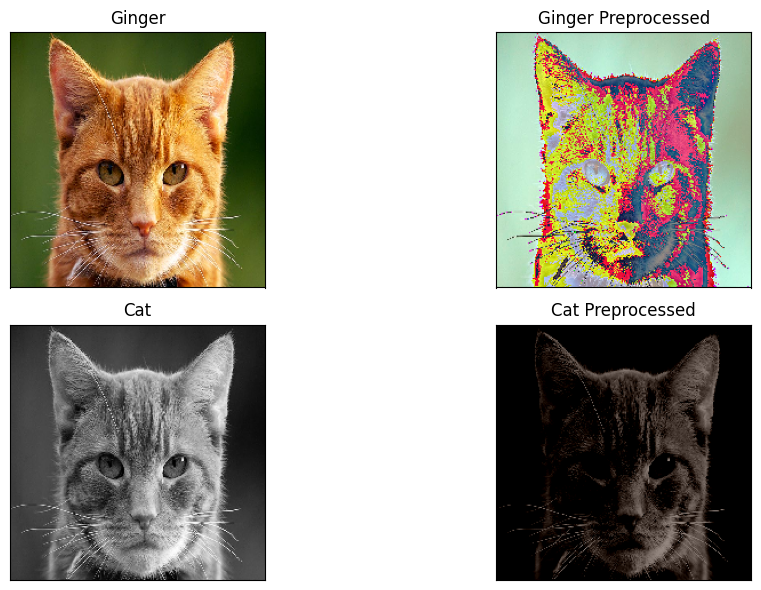

In [136]:
plot_image_subplots([ginger, ginger_input, cat, cat_input], titles=["Ginger", "Ginger Preprocessed", "Cat", "Cat Preprocessed"], ncols = 2, nrows = 2)

In [137]:
ginger_input = tf.expand_dims(ginger_input, axis=0)
ginger_input.shape

TensorShape([1, 224, 224, 3])

In [139]:
decode_predictions(resnet.predict(ginger_input))

35363/35363 [==============================] - 0s 0us/step


[[('n03938244', 'pillow', 0.8661304),
  ('n02317335', 'starfish', 0.046712045),
  ('n02321529', 'sea_cucumber', 0.0082598515),
  ('n02096294', 'Australian_terrier', 0.005817409),
  ('n03325584', 'feather_boa', 0.0051151137)]]